<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

import random
random.seed(10)
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'
test_dir = '/content/drive/My Drive/Colab Notebooks/charts/Test'

#DATA PROCESSING

In [11]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 50
batch_size = 16

In [12]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [13]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [14]:
#Performing augmentation on image scaling, zoom and  so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2,
	brightness_range=(0.6,0.9)) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

test_generator = test_datagen.flow_from_directory( 
	test_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
	shuffle = False)

train_noisy = noisy_generator(train_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

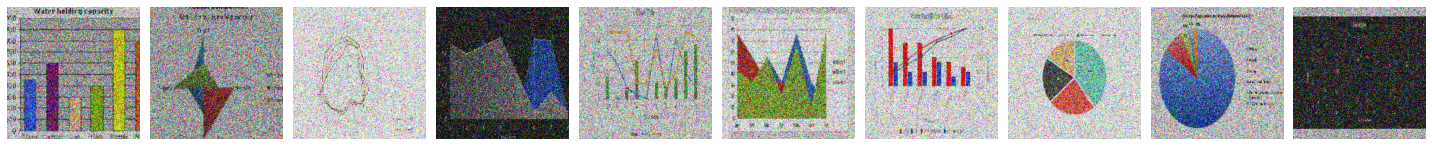

In [16]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:10])

#TRANSFER LEARNING

# <H4> MOBILENETV2 - transfer learning

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
base_model.trainable=False

In [ ]:
#top layer structure inspired from https://towardsdatascience.com/using-object-detection-for-complex-image-classification-scenarios-part-3-770d3fc5e3f7

top_layer = base_model.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dense(1024,activation='relu')(top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
top_layer = Dense(1024,activation='relu')(top_layer) #dense layer 2
top_layer = Dense(512,activation='relu')(top_layer) #dense layer 3
prediction_layer = Dense(7,activation='softmax')(top_layer) #final layer with softmax activation

tl_model = keras.Model(inputs= base_model.input, outputs=prediction_layer)

In [ ]:
lr =0.001
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(tl_model.trainable_variables)

8

In [ ]:
tl_history = tl_model.fit( 
	train_noisy,
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/50
35/35 [==============================] - 545s 16s/step - loss: 1.2242 - accuracy: 0.5607 - val_loss: 0.3981 - val_accuracy: 0.8750
Epoch 2/50
35/35 [==============================] - 15s 428ms/step - loss: 0.6178 - accuracy: 0.7804 - val_loss: 0.3012 - val_accuracy: 0.9062
Epoch 3/50
35/35 [==============================] - 15s 418ms/step - loss: 0.5643 - accuracy: 0.7964 - val_loss: 0.2157 - val_accuracy: 0.9219
Epoch 4/50
35/35 [==============================] - 15s 421ms/step - loss: 0.4970 - accuracy: 0.8429 - val_loss: 0.2778 - val_accuracy: 0.8906
Epoch 5/50
35/35 [==============================] - 15s 420ms/step - loss: 0.5199 - accuracy: 0.8018 - val_loss: 0.4499 - val_accuracy: 0.8516
Epoch 6/50
35/35 [==============================] - 15s 418ms/step - loss: 0.4510 - accuracy: 0.8339 - val_loss: 0.2623 - val_accuracy: 0.9141
Epoch 7/50
35/35 [==============================] - 15s 420ms/step - loss: 0.3190 - accuracy: 0.8839 - val_loss: 0.2765 - val_accuracy: 0.9062


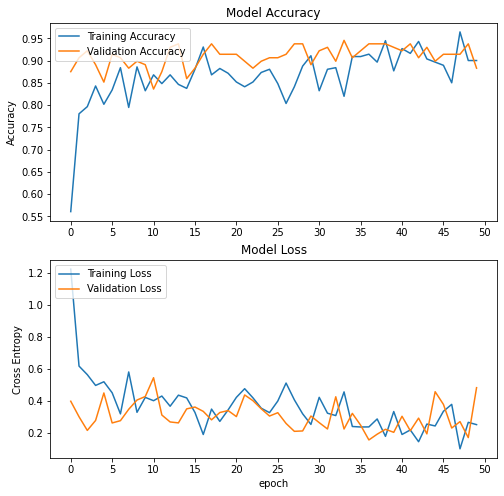

In [ ]:
#Plot based on https://www.tensorflow.org/tutorials/images/transfer_learning

acc = tl_history.history['accuracy']
val_acc = tl_history.history['val_accuracy']

loss = tl_history.history['loss']
val_loss = tl_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(tl_model.trainable_variables)

64

In [ ]:
fine_tune_epochs = 50
total_epochs =  50 + fine_tune_epochs

tl_history_fine = tl_model.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= tl_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 18s 524ms/step - loss: 0.7794 - accuracy: 0.7750 - val_loss: 1.0358 - val_accuracy: 0.8359
Epoch 51/100
35/35 [==============================] - 18s 506ms/step - loss: 0.4881 - accuracy: 0.8589 - val_loss: 0.8053 - val_accuracy: 0.8750
Epoch 52/100
35/35 [==============================] - 17s 498ms/step - loss: 0.4632 - accuracy: 0.8571 - val_loss: 1.1718 - val_accuracy: 0.8125
Epoch 53/100
35/35 [==============================] - 18s 506ms/step - loss: 0.3010 - accuracy: 0.8982 - val_loss: 1.2630 - val_accuracy: 0.8047
Epoch 54/100
35/35 [==============================] - 18s 503ms/step - loss: 0.2052 - accuracy: 0.9321 - val_loss: 1.2419 - val_accuracy: 0.8047
Epoch 55/100
35/35 [==============================] - 18s 506ms/step - loss: 0.2197 - accuracy: 0.9321 - val_loss: 1.4745 - val_accuracy: 0.7891
Epoch 56/100
35/35 [==============================] - 17s 497ms/step - loss: 0.3134 - accuracy: 0.8964 - val_loss: 1.0585 - val_ac

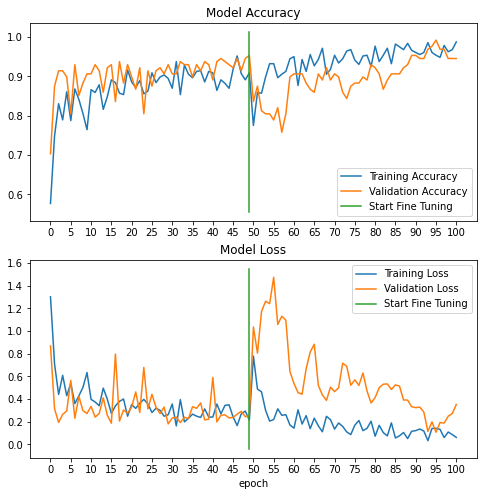

In [ ]:
acc += tl_history_fine.history['accuracy']
val_acc += tl_history_fine.history['val_accuracy']
loss += tl_history_fine.history['loss']
val_loss += tl_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

# <H4>VGG16 - transfer learning

In [ ]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg_base.trainable=False

In [ ]:
vgg_top_layer = vgg_base.output
vgg_top_layer = GlobalAveragePooling2D()(vgg_top_layer)
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_top_layer = Dense(1024,activation='relu')(vgg_top_layer) #dense layer 2
vgg_top_layer = Dense(512,activation='relu')(vgg_top_layer) #dense layer 3
vgg_prediction_layer = Dense(7,activation='softmax')(vgg_top_layer) #final layer with softmax activation

vgg_tl = keras.Model(inputs= vgg_base.input, outputs=vgg_prediction_layer)

In [ ]:
lr=0.001
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [ ]:
len(vgg_tl.trainable_variables)

8

In [ ]:
vgg_history = vgg_tl.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 18s 506ms/step - loss: 1.3390 - accuracy: 0.4982 - val_loss: 0.6710 - val_accuracy: 0.7734
Epoch 2/50
35/35 [==============================] - 18s 515ms/step - loss: 0.7540 - accuracy: 0.7143 - val_loss: 0.3771 - val_accuracy: 0.8828
Epoch 3/50
35/35 [==============================] - 18s 515ms/step - loss: 0.6251 - accuracy: 0.7625 - val_loss: 0.3718 - val_accuracy: 0.8594
Epoch 4/50
35/35 [==============================] - 18s 515ms/step - loss: 0.4110 - accuracy: 0.8500 - val_loss: 0.4802 - val_accuracy: 0.8438
Epoch 5/50
35/35 [==============================] - 18s 509ms/step - loss: 0.4640 - accuracy: 0.8429 - val_loss: 0.3118 - val_accuracy: 0.9062
Epoch 6/50
35/35 [==============================] - 18s 514ms/step - loss: 0.3721 - accuracy: 0.8696 - val_loss: 0.4531 - val_accuracy: 0.8359
Epoch 7/50
35/35 [==============================] - 18s 506ms/step - loss: 0.3068 - accuracy: 0.8750 - val_loss: 0.3371 - val_accuracy: 0.9062

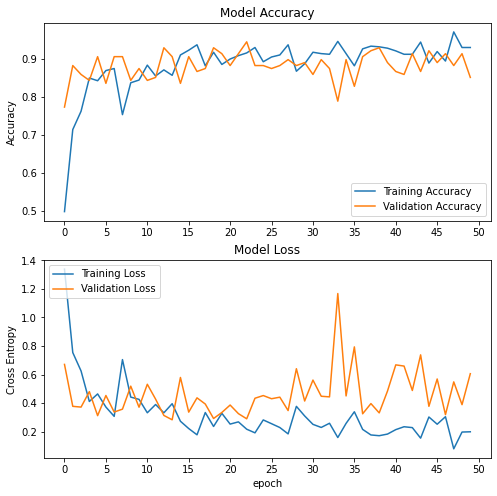

In [ ]:
vgg_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']

vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
vgg_base.trainable = True

print("Number of layers in the base model: ", len(vgg_base.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [ ]:
vgg_tl.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
len(vgg_tl.trainable_variables)

14

In [ ]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history_fine = vgg_tl.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 18s 522ms/step - loss: 0.7177 - accuracy: 0.7911 - val_loss: 0.4209 - val_accuracy: 0.9141
Epoch 51/100
35/35 [==============================] - 18s 522ms/step - loss: 0.3887 - accuracy: 0.9036 - val_loss: 0.3515 - val_accuracy: 0.9062
Epoch 52/100
35/35 [==============================] - 18s 521ms/step - loss: 0.3495 - accuracy: 0.8875 - val_loss: 0.3489 - val_accuracy: 0.9062
Epoch 53/100
35/35 [==============================] - 18s 509ms/step - loss: 0.2298 - accuracy: 0.9214 - val_loss: 0.3598 - val_accuracy: 0.9375
Epoch 54/100
35/35 [==============================] - 18s 517ms/step - loss: 0.2259 - accuracy: 0.9125 - val_loss: 0.6567 - val_accuracy: 0.8984
Epoch 55/100
35/35 [==============================] - 18s 518ms/step - loss: 0.3111 - accuracy: 0.8946 - val_loss: 0.5293 - val_accuracy: 0.8984
Epoch 56/100
35/35 [==============================] - 18s 513ms/step - loss: 0.3228 - accuracy: 0.8929 - val_loss: 0.2597 - val_ac

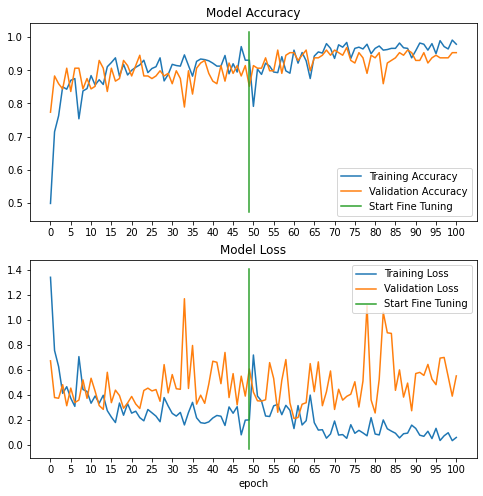

In [ ]:
vgg_acc += vgg_history_fine.history['accuracy']
vgg_val_acc += vgg_history_fine.history['val_accuracy']
vgg_loss += vgg_history_fine.history['loss']
vgg_val_loss += vgg_history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc, label='Training Accuracy')
plt.plot(vgg_val_acc, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss, label='Training Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

VGG16 - optimized

In [17]:
vgg_base_opt = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base_opt.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [18]:
vgg_base_opt.trainable=False

In [19]:
vgg_top_layer_opt = vgg_base_opt.output
vgg_top_layer_opt = GlobalAveragePooling2D()(vgg_top_layer_opt)
vgg_top_layer_opt = Dense(1024,activation='relu')(vgg_top_layer_opt) #we add dense layers so that the model can learn more complex functions and classify for better results.
#vgg_top_layer_opt = Dense(512,activation='relu')(vgg_top_layer_opt) #dense layer 3
vgg_prediction_layer_opt = Dense(7,activation='softmax')(vgg_top_layer_opt) #final layer with softmax activation

vgg_tl_opt = keras.Model(inputs= vgg_base_opt.input, outputs=vgg_prediction_layer_opt)

In [20]:
lr=0.001
vgg_tl_opt.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [21]:
len(vgg_tl_opt.trainable_variables)

4

In [22]:
vgg_history_opt = vgg_tl_opt.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 759s 22s/step - loss: 1.3919 - accuracy: 0.5321 - val_loss: 0.8146 - val_accuracy: 0.8438
Epoch 2/50
35/35 [==============================] - 15s 427ms/step - loss: 0.7302 - accuracy: 0.7946 - val_loss: 0.4484 - val_accuracy: 0.9297
Epoch 3/50
35/35 [==============================] - 15s 432ms/step - loss: 0.6304 - accuracy: 0.7964 - val_loss: 0.3927 - val_accuracy: 0.9062
Epoch 4/50
35/35 [==============================] - 15s 426ms/step - loss: 0.3980 - accuracy: 0.8732 - val_loss: 0.3923 - val_accuracy: 0.8672
Epoch 5/50
35/35 [==============================] - 15s 427ms/step - loss: 0.4320 - accuracy: 0.8446 - val_loss: 0.2533 - val_accuracy: 0.9297
Epoch 6/50
35/35 [==============================] - 15s 426ms/step - loss: 0.4255 - accuracy: 0.8625 - val_loss: 0.2313 - val_accuracy: 0.9375
Epoch 7/50
35/35 [==============================] - 15s 429ms/step - loss: 0.3839 - accuracy: 0.8732 - val_loss: 0.2385 - val_accuracy: 0.9375


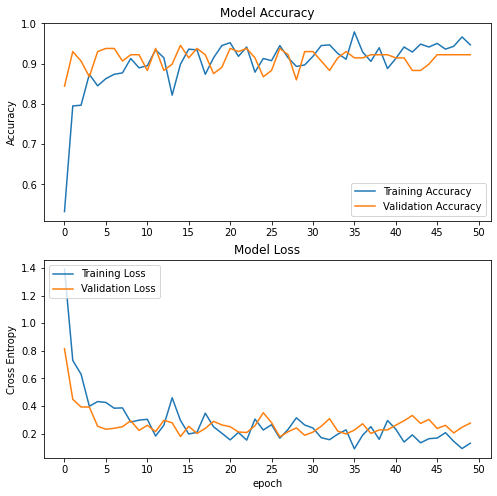

In [23]:
vgg_acc_opt = vgg_history_opt.history['accuracy']
vgg_val_acc_opt = vgg_history_opt.history['val_accuracy']

vgg_loss_opt = vgg_history_opt.history['loss']
vgg_val_loss_opt = vgg_history_opt.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc_opt, label='Training Accuracy')
plt.plot(vgg_val_acc_opt, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss_opt, label='Training Loss')
plt.plot(vgg_val_loss_opt, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
vgg_base_opt.trainable = True

print("Number of layers in the base model: ", len(vgg_base_opt.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base_opt.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [25]:
vgg_tl_opt.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [26]:
len(vgg_tl_opt.trainable_variables)

10

In [27]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history_fine_opt = vgg_tl_opt.fit( 
	train_noisy, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history_opt.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 50/100
35/35 [==============================] - 15s 430ms/step - loss: 0.7014 - accuracy: 0.7821 - val_loss: 0.2853 - val_accuracy: 0.8906
Epoch 51/100
35/35 [==============================] - 15s 429ms/step - loss: 0.3899 - accuracy: 0.8607 - val_loss: 0.2731 - val_accuracy: 0.9141
Epoch 52/100
35/35 [==============================] - 15s 425ms/step - loss: 0.1789 - accuracy: 0.9411 - val_loss: 0.0824 - val_accuracy: 0.9688
Epoch 53/100
35/35 [==============================] - 15s 431ms/step - loss: 0.3736 - accuracy: 0.8857 - val_loss: 0.2152 - val_accuracy: 0.9531
Epoch 54/100
35/35 [==============================] - 15s 428ms/step - loss: 0.2867 - accuracy: 0.9125 - val_loss: 0.4765 - val_accuracy: 0.9219
Epoch 55/100
35/35 [==============================] - 15s 427ms/step - loss: 0.1444 - accuracy: 0.9482 - val_loss: 0.7889 - val_accuracy: 0.9141
Epoch 56/100
35/35 [==============================] - 15s 429ms/step - loss: 0.1604 - accuracy: 0.9446 - val_loss: 0.3440 - val_ac

In [28]:
vgg_tl_opt.save('/content/drive/My Drive/Colab Notebooks/Transfer learning model', save_format = 'tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Transfer learning model/assets


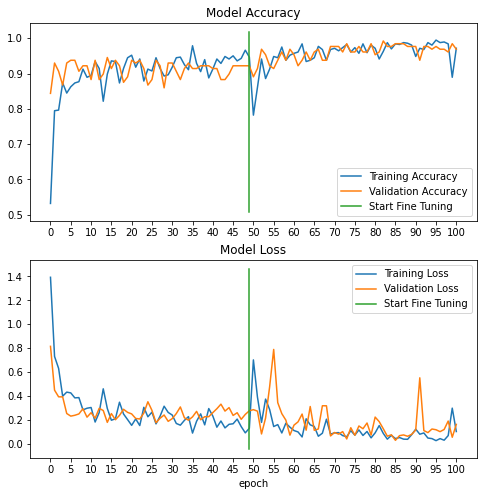

In [29]:
vgg_acc_opt += vgg_history_fine_opt.history['accuracy']
vgg_val_acc_opt += vgg_history_fine_opt.history['val_accuracy']
vgg_loss_opt += vgg_history_fine_opt.history['loss']
vgg_val_loss_opt += vgg_history_fine_opt.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc_opt, label='Training Accuracy')
plt.plot(vgg_val_acc_opt, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss_opt, label='Training Loss')
plt.plot(vgg_val_loss_opt, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
#Confusion matrix plotting function taken from https://sites.google.com/view/amarnath-r/keras-deep-learning-image-classification-a-simple-example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.7  0.05 0.25 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.95 0.05 0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


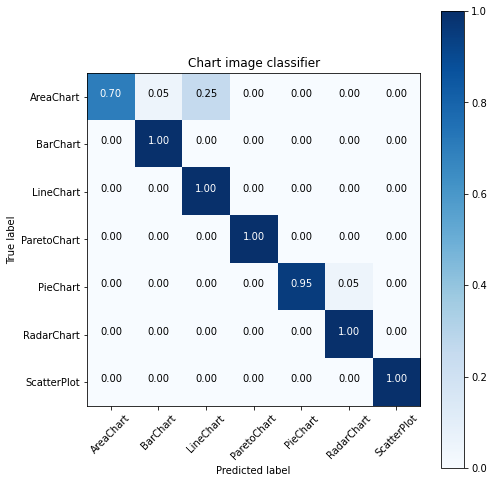

In [35]:
y_pred_1 = vgg_tl_opt.predict(test_generator, batch_size=16)
y_prediction_1 = np.argmax(y_pred_1 , axis=1)
conf_matrix_1=confusion_matrix(test_generator.classes, y_prediction_1)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_1 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_1, classes=target_names, normalize=True, title='Chart image classifier')

ABLATION STUDY

remove data aug and noise

In [40]:
train_datagen_2 = ImageDataGenerator(rescale=1. / 255)

val_datagen_2 = ImageDataGenerator(rescale=1. / 255) 

test_datagen_2 = ImageDataGenerator(rescale=1. /255)

train_generator_2 = train_datagen_2.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

validation_generator_2 = val_datagen_2.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

test_generator_2 = test_datagen_2.flow_from_directory( 
	test_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical', 
  shuffle=False)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [41]:
vgg_base2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [45]:
vgg_base2.trainable=False

In [46]:
vgg_top_layer2 = vgg_base2.output
vgg_top_layer2 = GlobalAveragePooling2D()(vgg_top_layer2)
vgg_top_layer2 = Dense(1024,activation='relu')(vgg_top_layer2) #we add dense layers so that the model can learn more complex functions and classify for better results.
#vgg_top_layer_opt = Dense(512,activation='relu')(vgg_top_layer_opt) #dense layer 3
vgg_prediction_layer2 = Dense(7,activation='softmax')(vgg_top_layer2) #final layer with softmax activation

vgg_tl2 = keras.Model(inputs= vgg_base2.input, outputs=vgg_prediction_layer2)

In [47]:
lr=0.001
vgg_tl2.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [48]:
vgg_history2 = vgg_tl2.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=50, 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 6s 160ms/step - loss: 1.2114 - accuracy: 0.6161 - val_loss: 0.6136 - val_accuracy: 0.9375
Epoch 2/50
35/35 [==============================] - 5s 152ms/step - loss: 0.4325 - accuracy: 0.9054 - val_loss: 0.3295 - val_accuracy: 0.9141
Epoch 3/50
35/35 [==============================] - 5s 153ms/step - loss: 0.2380 - accuracy: 0.9393 - val_loss: 0.2353 - val_accuracy: 0.9531
Epoch 4/50
35/35 [==============================] - 5s 153ms/step - loss: 0.1676 - accuracy: 0.9786 - val_loss: 0.1974 - val_accuracy: 0.9375
Epoch 5/50
35/35 [==============================] - 5s 148ms/step - loss: 0.1219 - accuracy: 0.9768 - val_loss: 0.1926 - val_accuracy: 0.9297
Epoch 6/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0974 - accuracy: 0.9821 - val_loss: 0.1570 - val_accuracy: 0.9531
Epoch 7/50
35/35 [==============================] - 5s 148ms/step - loss: 0.0822 - accuracy: 0.9821 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 

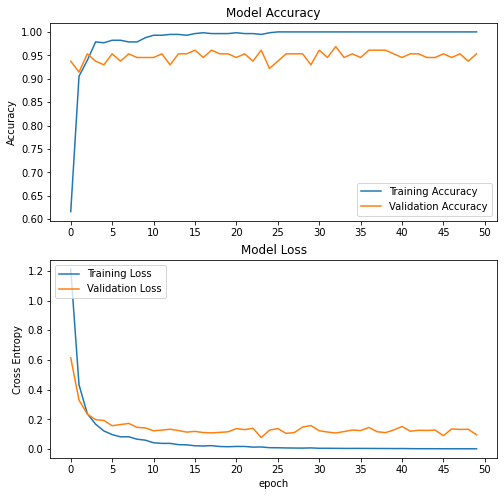

In [50]:
vgg_acc2 = vgg_history2.history['accuracy']
vgg_val_acc2 = vgg_history2.history['val_accuracy']

vgg_loss2 = vgg_history2.history['loss']
vgg_val_loss2 = vgg_history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc2, label='Training Accuracy')
plt.plot(vgg_val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss2, label='Training Loss')
plt.plot(vgg_val_loss2, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
vgg_base2.trainable = True

print("Number of layers in the base model: ", len(vgg_base2.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [52]:
vgg_tl2.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [53]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history2_fine = vgg_tl2.fit( 
	train_generator_2, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history2.epoch[-1], 
	validation_data=validation_generator_2, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 50/100
35/35 [==============================] - 6s 160ms/step - loss: 0.1499 - accuracy: 0.9607 - val_loss: 0.1507 - val_accuracy: 0.9453
Epoch 51/100
35/35 [==============================] - 5s 152ms/step - loss: 0.0391 - accuracy: 0.9857 - val_loss: 0.1746 - val_accuracy: 0.9609
Epoch 52/100
35/35 [==============================] - 5s 149ms/step - loss: 0.0325 - accuracy: 0.9929 - val_loss: 0.2570 - val_accuracy: 0.9297
Epoch 53/100
35/35 [==============================] - 5s 151ms/step - loss: 0.0449 - accuracy: 0.9893 - val_loss: 0.2456 - val_accuracy: 0.9375
Epoch 54/100
35/35 [==============================] - 5s 151ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1843 - val_accuracy: 0.9531
Epoch 55/100
35/35 [==============================] - 5s 151ms/step - loss: 3.5110e-04 - accuracy: 1.0000 - val_loss: 0.1608 - val_accuracy: 0.9609
Epoch 56/100
35/35 [==============================] - 5s 151ms/step - loss: 8.6290e-05 - accuracy: 1.0000 - val_loss: 0.1568 - val_a

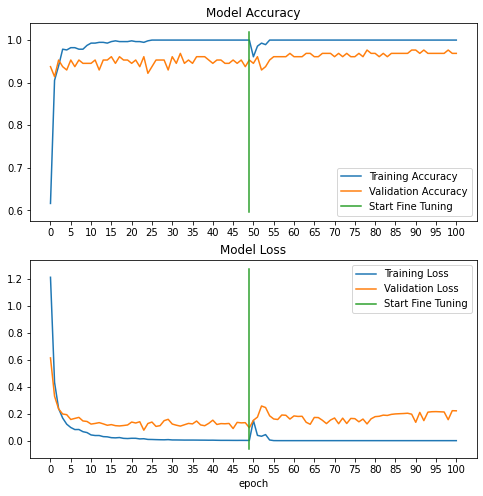

In [54]:
vgg_acc2 += vgg_history2_fine.history['accuracy']
vgg_val_acc2 += vgg_history2_fine.history['val_accuracy']
vgg_loss2 += vgg_history2_fine.history['loss']
vgg_val_loss2 += vgg_history2_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc2, label='Training Accuracy')
plt.plot(vgg_val_acc2, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss2, label='Training Loss')
plt.plot(vgg_val_loss2, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

Normalized confusion matrix
[[0.8 0.  0.1 0.  0.  0.  0.1]
 [0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]]


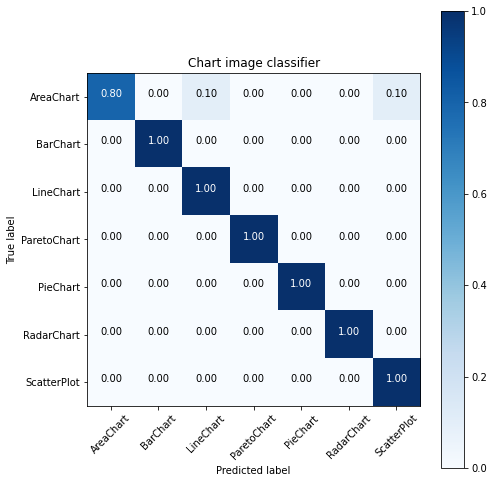

In [55]:
y_pred_2 = vgg_tl2.predict(test_generator, batch_size=16)
y_prediction_2 = np.argmax(y_pred_2 , axis=1)
conf_matrix_2=confusion_matrix(test_generator_2.classes, y_prediction_2)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_2 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_2, classes=target_names, normalize=True, title='Chart image classifier')

 remove gaussian noise

In [60]:
vgg_base3 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [61]:
vgg_base3.trainable=False

In [62]:
vgg_top_layer3 = vgg_base3.output
vgg_top_layer3 = GlobalAveragePooling2D()(vgg_top_layer3)
vgg_top_layer3 = Dense(1024,activation='relu')(vgg_top_layer3) #we add dense layers so that the model can learn more complex functions and classify for better results.
vgg_prediction_layer3 = Dense(7,activation='softmax')(vgg_top_layer3) #final layer with softmax activation

vgg_tl3 = keras.Model(inputs= vgg_base3.input, outputs=vgg_prediction_layer3)

In [63]:
lr=0.001
vgg_tl3.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy']) 

In [64]:
vgg_history3 = vgg_tl3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=50, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
35/35 [==============================] - 11s 325ms/step - loss: 1.1757 - accuracy: 0.6214 - val_loss: 0.5700 - val_accuracy: 0.9141
Epoch 2/50
35/35 [==============================] - 11s 315ms/step - loss: 0.4499 - accuracy: 0.9018 - val_loss: 0.3355 - val_accuracy: 0.9062
Epoch 3/50
35/35 [==============================] - 11s 316ms/step - loss: 0.2725 - accuracy: 0.9446 - val_loss: 0.2246 - val_accuracy: 0.9453
Epoch 4/50
35/35 [==============================] - 11s 319ms/step - loss: 0.2127 - accuracy: 0.9464 - val_loss: 0.2086 - val_accuracy: 0.9453
Epoch 5/50
35/35 [==============================] - 11s 318ms/step - loss: 0.1649 - accuracy: 0.9607 - val_loss: 0.2500 - val_accuracy: 0.9375
Epoch 6/50
35/35 [==============================] - 11s 315ms/step - loss: 0.1476 - accuracy: 0.9554 - val_loss: 0.1910 - val_accuracy: 0.9219
Epoch 7/50
35/35 [==============================] - 11s 315ms/step - loss: 0.1275 - accuracy: 0.9643 - val_loss: 0.1776 - val_accuracy: 0.9297

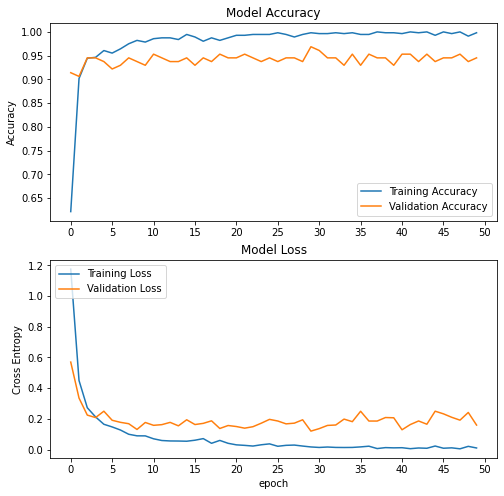

In [65]:
vgg_acc3 = vgg_history3.history['accuracy']
vgg_val_acc3 = vgg_history3.history['val_accuracy']

vgg_loss3 = vgg_history3.history['loss']
vgg_val_loss3 = vgg_history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc3, label='Training Accuracy')
plt.plot(vgg_val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss3, label='Training Loss')
plt.plot(vgg_val_loss3, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.xticks(np.arange(0,55, 5))
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

In [66]:
vgg_base3.trainable = True

print("Number of layers in the base model: ", len(vgg_base3.layers))

fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base3.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [67]:
vgg_tl3.compile(optimizer=tf.optimizers.Adam(learning_rate=lr/10),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [68]:
fine_tune_epochs = 50
total_epochs =  epochs + fine_tune_epochs

vgg_history3_fine = vgg_tl3.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=total_epochs,
  initial_epoch= vgg_history3.epoch[-1], 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size)

Epoch 50/100
35/35 [==============================] - 11s 328ms/step - loss: 0.2005 - accuracy: 0.9518 - val_loss: 0.2722 - val_accuracy: 0.9531
Epoch 51/100
35/35 [==============================] - 11s 324ms/step - loss: 0.0601 - accuracy: 0.9804 - val_loss: 0.4460 - val_accuracy: 0.8750
Epoch 52/100
35/35 [==============================] - 11s 321ms/step - loss: 0.1012 - accuracy: 0.9696 - val_loss: 0.1247 - val_accuracy: 0.9766
Epoch 53/100
35/35 [==============================] - 11s 319ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 0.2059 - val_accuracy: 0.9453
Epoch 54/100
35/35 [==============================] - 11s 320ms/step - loss: 0.0318 - accuracy: 0.9893 - val_loss: 0.1866 - val_accuracy: 0.9453
Epoch 55/100
35/35 [==============================] - 11s 321ms/step - loss: 0.0223 - accuracy: 0.9946 - val_loss: 0.2108 - val_accuracy: 0.9531
Epoch 56/100
35/35 [==============================] - 11s 321ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.1610 - val_ac

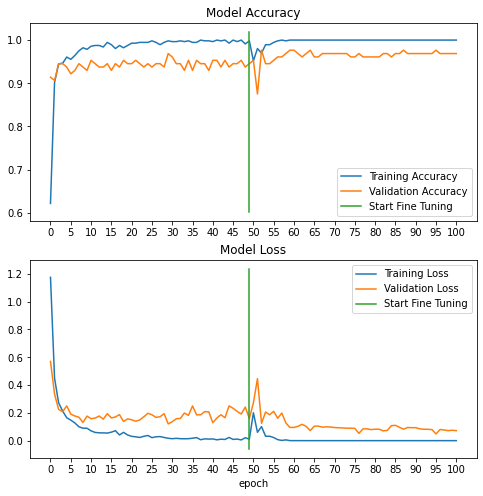

In [69]:
vgg_acc3 += vgg_history3_fine.history['accuracy']
vgg_val_acc3 += vgg_history3_fine.history['val_accuracy']
vgg_loss3 += vgg_history3_fine.history['loss']
vgg_val_loss3 += vgg_history3_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(vgg_acc3, label='Training Accuracy')
plt.plot(vgg_val_acc3, label='Validation Accuracy')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(2, 1, 2)
plt.plot(vgg_loss3, label='Training Loss')
plt.plot(vgg_val_loss3, label='Validation Loss')
plt.xticks(np.arange(0,105, 5))
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.show()

Normalized confusion matrix
[[0.75 0.05 0.15 0.   0.   0.   0.05]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.1  0.   0.   0.   0.   0.9 ]]


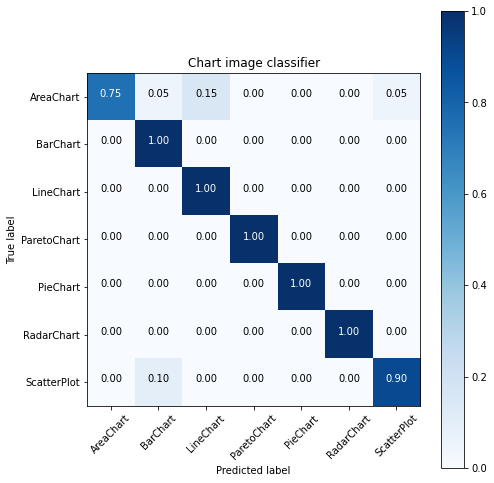

In [71]:
y_pred_3 = vgg_tl3.predict(test_generator, batch_size=16)
y_prediction_3 = np.argmax(y_pred_3 , axis=1)
conf_matrix_3=confusion_matrix(test_generator.classes, y_prediction_3)
target_names = ['AreaChart', 'BarChart', 'LineChart', 'ParetoChart', 'PieChart', 'RadarChart', 'ScatterPlot']
final_confusion_matrix_3 = plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix_3, classes=target_names, normalize=True, title='Chart image classifier')